In [1]:
import pandas as pd
import numpy as np

In [2]:
df_cluster = pd.read_csv('symbols-clusters.csv') 
df_correlation =  pd.read_csv('symbols-correlation-normal.csv ', index_col='Symbol')
symbols = df_correlation.index
n_clusters = len(df_cluster.Cluster.unique())

In [20]:
import math

stdv = {"ABC":0.3,"XYZ":0.2}

tickersCorr = ["ABC","XYZ"]

# Assuming a 0.5 correlation here is the correlation matrix
c = [[1,0.5],[0.5,1]]

def varCovarMatrix(stocksInPortfolio):
    cm = np.array(c)
    vcv = []
    for eachStock in stocksInPortfolio:
        row = []
        for ticker in stocksInPortfolio:
            if eachStock == ticker:
                variance = math.pow(stdv[ticker],2)
                row.append(variance)
            else:
                cov = stdv[ticker]*stdv[eachStock]* cm[tickersCorr.index(ticker)][tickersCorr.index(eachStock)]
                row.append(cov)
        vcv.append(row)

    vcvmat = np.mat(vcv)

    return vcvmat


print(varCovarMatrix(["ABC","XYZ"]))

[[0.09 0.03]
 [0.03 0.04]]


In [3]:
def create_portfolio_randomly(symbols, n=10):
    selected_symbols =  np.random.choice(symbols, n, replace = False)
    return selected_symbols

In [4]:
def create_portfolio_clusterbased(df_cluster, cluster_num, n = 10 , random_select = True):
    selected_symbols = []
    
    max_cluster = cluster_num
    cls = 1
    if random_select == False:
        cls = np.random.randint(1,5,1)[0]
        max_cluster = 1

    for i in range(n):
        symbol = df_cluster[df_cluster['Cluster'] == cls].sample(1).to_numpy()[0][0]
        selected_symbols.append(symbol)

        if max_cluster == 1:
            continue
            
        if cls < max_cluster:
            cls += 1
        else:
            cls = 1       

    return np.array(selected_symbols)

In [5]:
def calculate_return(tickers , df_correlation, from_date , to_date):
    
    file_temp = 'stocks/{0}.csv'
    
    returns  =  []
    close_price = []
    
    for ticker in tickers:
        
        filename = ('stocks/{0}.csv').format(ticker)
        df = pd.read_csv(filename)     
        df = df.loc[ (df['Date'] >= from_date) & (df['Date'] <= to_date)]        
        ticker_return  =  (df.iloc[-1]['Adj Close'] -  df.iloc[0]['Adj Close'])       
        
        close_price.append(df.iloc[0]['Adj Close'])
        returns.append(ticker_return)
        
    data = {'Symbol': tickers,'Price':close_price,  'Return': returns}
    df_portfolio = pd.DataFrame(data , columns=['Symbol','Price' , 'Return'] )
    df_portfolio = df_portfolio.set_index('Symbol')
    df_portfolio['Weight'] = df_portfolio['Price'].transform(lambda x: x/x.sum())
    
    
    agg = df_portfolio.sum().reindex()
    portfolio_profit = agg['Price'] / agg['Return']
    
    wtg = df_portfolio['Weight'].to_numpy() 
    correlation =  df_correlation.loc[tickers, tickers].to_numpy()
    portfolio_risk = np.dot(wtg, correlation).dot(wtg.T)
    
    
    return df_portfolio , portfolio_profit , portfolio_risk

In [13]:
counter = 50

random_results = []
cluster_results = []

for i in range(counter):
    
    #random_portfolio = create_portfolio_clusterbased(df_cluster, n_clusters , 10 , False)
    random_portfolio = create_portfolio_randomly(symbols, 5) 
    cluster_based_portfolio = create_portfolio_clusterbased(df_cluster , n_clusters , 5 , True)

    _ , random_profit , random_risk = calculate_return(random_portfolio, df_correlation, '2019-10-01','2019-12-30')
    _ , cluster_profit, cluster_risk = calculate_return(cluster_based_portfolio , df_correlation, '2019-10-01','2019-12-30')
    
    random_results.append([random_profit , random_risk])
    cluster_results.append([cluster_profit , cluster_risk])
    
random_results = np.array(random_results)  
cluster_results = np.array(cluster_results)    

In [14]:
columns = ['Cluster_Return','Cluster_Risk','Random_Return','Random_Risk']
data = {'Cluster_Return':cluster_results[:, 0] ,'Cluster_Risk':cluster_results[:, 1],
         'Random_Return':random_results[:, 0],'Random_Risk':random_results[:, 1]}
df_result = pd.DataFrame(data, columns = columns)
df_result.describe()

,Cluster_Return,Cluster_Risk,Random_Return,Random_Risk
count,50.000000,50.000000,50.000000,50.000000
mean,13.469623,0.031372,17.188316,0.026799
std,46.233228,0.142834,178.359062,0.157519
min,-206.185640,-0.174762,-736.509893,-0.239110
25%,6.447221,-0.071181,6.481003,-0.057871
50%,10.574109,0.020809,10.963756,0.012577
75%,14.976633,0.119065,15.186402,0.091020
max,176.647283,0.475907,997.589837,0.658254


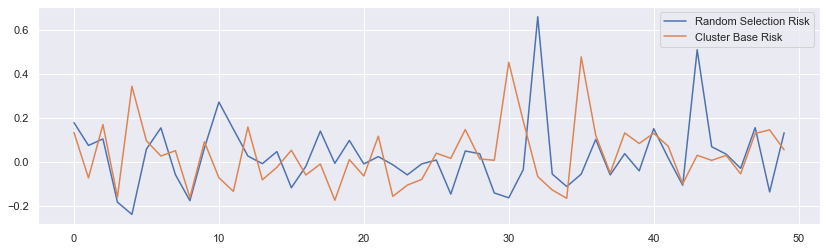

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(14, 4)})
plt.plot(range(counter), random_results[:, 1], label = 'Random Selection Risk')
plt.plot(range(counter), cluster_results[:, 1], label = 'Cluster Base Risk')

plt.legend()
plt.show()

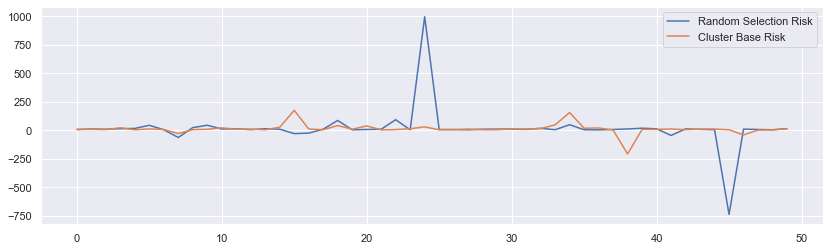

In [19]:
sns.set(rc={'figure.figsize':(14, 4)})
plt.plot(range(counter), random_results[:, 0], label = 'Random Selection Risk')
plt.plot(range(counter), cluster_results[:, 0], label = 'Cluster Base Risk')

plt.legend()
plt.savefig('fig/random_vs_cluster_portfolio.png', format='png', dpi=400 ,bbox_inches='tight', pad_inches=0)
plt.show()


In [17]:
df_result

,Cluster_Return,Cluster_Risk,Random_Return,Random_Risk
0,8.340158,0.133226,8.599363,0.177593
1,9.538612,-0.073206,12.665918,0.074096
2,7.245114,0.169043,11.147710,0.103582
3,23.697837,-0.160524,15.549978,-0.183321
4,5.956237,0.342746,17.811547,-0.239110
5,13.270445,0.094991,45.418344,0.057617
6,8.551643,0.025963,6.034415,0.153785
7,-27.274686,0.050191,-61.537864,-0.058462
8,7.215293,-0.162790,25.027356,-0.176703
9,10.406773,0.090477,45.943907,0.062016
